In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.sparse import issparse, vstack, hstack, csr_matrix as sparse
%matplotlib inline

In [2]:
%%HTML
<style type="text/css">
table, td{
    border-style: solid;
}
th {
  background-color: #4CAF50;
  color: white;
}
tr:nth-child(even) {background-color: #f0f0f0;}
tr:hover {background-color: #4CAF50;}

In [3]:
from pypower.api import case30pwl, case30Q 
from pypower.api import case30, ppoption, runpf, printpf, runopf
from pypower.loadcase import loadcase

from drawings import *
from utils import *
from constr_setting import *
from pypower.api import opf_consfcn, opf_costfcn
from pypower.idx_bus import BUS_TYPE, REF, VM, VA, MU_VMAX, MU_VMIN, LAM_P, LAM_Q
from scipy.optimize import minimize, nnls, linprog

In [4]:
bus_cols, gen_cols, brch_cols, cost_cols = get_cols()

In [5]:
ppc = case30()

ppopt = ppoption(PF_ALG=1, RETURN_RAW_DER=True, OPF_FLOW_LIM=1)
#ppopt

In [6]:
#pd.DataFrame(ppc['bus'], columns=bus_cols[: LAM_P])

In [7]:
#pd.DataFrame(ppc['gen'], columns=gen_cols[: MU_PMAX])

In [8]:
gens = ppc['gen'][:, 0]

load_list = []

for bus_str in ppc['bus']:
    tmp = np.zeros(21)
    if bus_str[0] not in gens:
        if bus_str[0] not in gens:
            #print('load #%d' % bus_str[0])
            tmp[0] = bus_str[0]

            tmp[1] = -30.#bus_str[2]
            tmp[2] = -15.#bus_str[3]

            tmp[3] = -0.0001
            tmp[4] = -15.

            tmp[5] = bus_str[7]
            tmp[6] = 100.

            tmp[7] = 1.

            #fixed here
            tmp[8] = -0.0001
            tmp[9] = -30.

            bus_str[2], bus_str[3] = 0., 0.
            load_list.append(tmp)

ppc['gen'] = np.concatenate((ppc['gen'], np.array(load_list)))

In [9]:
#pd.DataFrame(ppc['gen'], columns=gen_cols[: MU_PMAX])

In [10]:
#pd.DataFrame(ppc['branch'], columns=brch_cols[: PF])

In [11]:
alpha = 0.01
#bound max flow 3 + 1 <-> 11 + 1
ppc['branch'][14][5] *= alpha
#bound max flow 9 + 1 <-> 16 + 1
ppc['branch'][25][5] *= alpha
#bound max flow 27 <-> 26
#ppc['branch'][35][5] *= alpha
#bound max flow 18 <-> 19
ppc['branch'][23][5] *= alpha
#bound max flow 22 <-> 23
ppc['branch'][31][5] *= alpha

In [12]:
#pd.DataFrame(ppc['branch'], columns=brch_cols[: PF])

In [13]:
#results['nln']['mu']['u'].keys(), results['nln']['mu']['l'].keys()

In [14]:
#results['om']

## Data preparation to fulfil the task

Bus data:

<table>
    <tr>
            <td> $bus_i$ </td>
            <td> type </td>
            <td> $P_d$ </td>
            <td> $Q_d$ </td>
            <td> $G_s$ </td>
            <td> $B_s$ </td>
            <td> area </td>
            <td> $V_m$ </td>
            <td> $V_a$ </td>
            <td> base~KV </td>
            <td> zone </td>
            <td> $V_{max}$ </td>
            <td> $V_{min}$ </td>
    </tr>
</table>

Generator data:

<table>
    <tr>
            <td> $bus$ </td>
            <td> $P_g$ </td>
            <td> $Q_g$ </td>
            <td> $Q_{max}$ </td>
            <td> $Q_{min}$ </td>
            <td> mBase </td>
            <td> status </td>
            <td> $P_{max}$ </td>
            <td> $P_{min}$ </td>
            <td> $\ldots$ </td>
    </tr>
</table>

Generator cost data has the following structure:

<table>
    <tr>
            <td> 1 </td>
            <td> startup </td>
            <td> shutdown </td>
            <td> n </td>
            <td> $x_1$ </td>
            <td> $y_1$ </td>
            <td> $\ldots$ </td>
            <td> $x_n$ </td>
            <td> $y_n$ </td>
    </tr>
    <tr>
            <td> 2 </td>
            <td> startup </td>
            <td> shutdown </td>
            <td> n </td>
            <td> $c_{n - 1}$ </td>
            <td> $\ldots$ </td>
            <td> $\ldots$ </td>
            <td> $\ldots$ </td>
            <td> $c_0$ </td>
    </tr>
</table>

Convert cost function to linear changing the order of polynom to 1

In [15]:
ppc['gencost'][:,3] = np.ones(ppc['gencost'].shape[0]) * 2
ppc['gencost'] = ppc['gencost'][:,[0,1,2,3,5,6]]
pd.DataFrame(ppc['gencost'])

,0,1,2,3,4,5
0,2.0,0.0,0.0,2.0,2.00,0.0
1,2.0,0.0,0.0,2.0,1.75,0.0
2,2.0,0.0,0.0,2.0,1.00,0.0
3,2.0,0.0,0.0,2.0,3.25,0.0
4,2.0,0.0,0.0,2.0,3.00,0.0
5,2.0,0.0,0.0,2.0,3.00,0.0


In [16]:
cost_list = []

for load in load_list:
    cost_list.append(np.array([2., 0., 0., 2., -10., 0]))
    
ppc['gencost'] = np.concatenate((ppc['gencost'], np.array(cost_list)))

In [17]:
#ppc['gencost'][:, 4] = np.zeros(ppc['gencost'].shape[0])

ppc['gencost'][-6: , 4] = 0.
#pd.DataFrame(ppc['gencost'])

Also it contains only generation costs, to satisfy welfare cost function:

\begin{equation}
f = \sum\limits_{d \in {\cal D}} C_dP_d - \sum\limits_{g \in {\cal G}} C_gP_g = {\bf C}_d^{\top}{\bf P}_d - {\bf C}_g^{\top}{\bf P}_g\to \max
\end{equation}

From `MATPOWER` documentation the standard OPF problem takes the following form:

\begin{align}
\min_x~& f(x)\\
s.t.~&g(x) = 0\\
&h(x) \leq 0\\
x_{{\rm min}} &\leq x \leq x_{{\rm max}}
\end{align}

Then

\begin{equation}
f = {\bf C}_g^{\top}{\bf P}_g - {\bf C}_d^{\top}{\bf P}_d \to \min
\end{equation}


In [18]:
ppopt = ppoption(VERBOSE=0)
results = runopf(ppc, ppopt)


Converged in 0.97 seconds
Objective Function Value = 41.01 $/hr
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             30     Total Gen Capacity     335.0        -455.0 to 405.9
Generators        30     On-line Capacity       335.0        -455.0 to 405.9
Committed Gens    30     Generation (actual)     26.0               3.0
Loads              2     Load                    24.9              14.3
  Fixed            2       Fixed                 24.9              14.3
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             2     Shunt (inj)             -0.0               0.2
Branches          41     Losses (I^2 * Z)         1.05              6.43
Transformers       0     Branch Charging (inj)     -               17.5
Inter-ties         7     Total Inter-tie

In [19]:
#pd.DataFrame(results['bus'], columns=bus_cols)

In [20]:
#pd.DataFrame(results['gen'], columns=gen_cols)

In [21]:
ppc['gencost'][:,4][: 6] = 400
ppc['gencost'][:,4][6: ] = -10
ppc['gencost'][:,4][-2: ] = -10

In [22]:
#ppc['gencost'][0, 5] = 500.
#ppc['gencost'][1, 5] = 500.
#ppc['gencost'][3, 5] = 300.
#ppc['gencost'][2, 5] = 100.
#ppc['gencost'][4, 5] = 5.
#ppc['gencost'][5, 5] = 5.
ppc['gencost'][0, 4] = 15.
ppc['gencost'][1, 4] = 12.
ppc['gencost'][3, 4] = 15.
ppc['gencost'][2, 4] = 10.
ppc['gencost'][4, 4] = 50.
ppc['gencost'][5, 4] = 30.
ppc['gencost'][:,4:] *= 100.
#pd.DataFrame(ppc['gencost'])

In [23]:
ppc['gencost'][6:,4] *= 2.5

In [24]:
results = runopf(ppc, ppopt)


Converged in 2.99 seconds
Objective Function Value = 36857.61 $/hr
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             30     Total Gen Capacity     335.0        -455.0 to 405.9
Generators        30     On-line Capacity       335.0        -455.0 to 405.9
Committed Gens    30     Generation (actual)     25.5              -0.8
Loads              2     Load                    24.9              14.3
  Fixed            2       Fixed                 24.9              14.3
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             2     Shunt (inj)             -0.0               0.3
Branches          41     Losses (I^2 * Z)         0.59              2.76
Transformers       0     Branch Charging (inj)     -               17.6
Inter-ties         7     Total Inter-

In [25]:
#pd.DataFrame(results['bus'], columns=bus_cols)
#pd.DataFrame(results['gen'], columns=gen_cols)

In [26]:
results.keys()

dict_keys(['version', 'baseMVA', 'bus', 'gen', 'branch', 'areas', 'gencost', 'order', 'om', 'x', 'mu', 'f', 'var', 'lin', 'nln', 'et', 'success', 'raw'])

In [27]:
vv, _, nn, _ = results['om'].get_idx()
vv, nn

({'i1': {'Va': 0, 'Vm': 30, 'Pg': 60, 'Qg': 90},
  'iN': {'Va': 30, 'Vm': 60, 'Pg': 90, 'Qg': 120},
  'N': {'Va': 30, 'Vm': 30, 'Pg': 30, 'Qg': 30}},
 {'i1': {'Pmis': 0, 'Qmis': 30, 'Sf': 60, 'St': 101},
  'iN': {'Pmis': 30, 'Qmis': 60, 'Sf': 101, 'St': 142},
  'N': {'Pmis': 30, 'Qmis': 30, 'Sf': 41, 'St': 41}})

In [28]:
dgT, dgeqT = get_Jac(ppc, ppopt, results)
muls = get_muls(results)
is_price_forming(results['gen'], results['gencost'], verbose=True)

Price forming bus #2	 C_g=1200.000000
Price forming bus #22	 C_g=1000.000000
Price forming bus #23	 C_g=5000.000000
Price forming bus #13	 C_g=3000.000000


[1, 21, 22, 12]

\begin{equation}
\mu = 
\begin{pmatrix}
{\bf 0}\\
\mu^{\max} - \mu^{\min}
\end{pmatrix}
\end{equation}


$$\sigma = (\sigma_{from}, \sigma_{to})^{\top}$$
as according to the original code (opf_consfcn)
$${\bf J}_S^T = ({\bf J}_{S~from}, {\bf J}_{S~to})$$

In [29]:
sigma = np.concatenate((muls['mu_s_from'], muls['mu_s_to']))

Let's obtain FOC for our OPF

\begin{align}
&\left(\frac{\partial L}{\partial {\bf X}}\right)^{\top} = {\bf J}^{\top}{\lambda} + {\bf J}_S^{\top}{\sigma} + {\mu} = 0\\
&\left(\frac{\partial L}{\partial {\bf P}_g}\right)^{\top} = {\bf C}_g - { \lambda}^P + {\pi}^{\max} - {\pi}^{\min} = 0,\\
&\left(\frac{\partial L}{\partial {\bf P}_d}\right)^{\top} = -{\bf C}_d + { \lambda}^P + {\psi}^{\max} - {\psi}^{\min} = 0,\\
&\left(\frac{\partial L}{\partial {\bf Q}_g}\right)^{\top} = {\bf 0} - { \lambda}^Q + {\rho}^{\max} - { \rho}^{\min} = 0
\end{align}

From here we should fix ${\lambda}^Q$ as we don't want to change ${\rho}^{\max}, { \rho}^{\min}$ and following we should recompute costs after obtaining new ${ \lambda}^P$ with ${\pi}^{\max}, {\pi}^{\min}, {\psi}^{\max}, {\psi}^{\min}$ from original solution.

$${\bf J}^T
\begin{bmatrix}
\lambda^P\\
\lambda^Q
\end{bmatrix}
=
\begin{bmatrix}
{\bf J}_P^T & {\bf J}_Q^T 
\end{bmatrix}
\begin{bmatrix}
\lambda^P\\
\lambda^Q
\end{bmatrix}
=
{\bf J}_P^T\lambda^P + {\bf J}_Q^T\lambda^Q
=
{\bf J}_P^T\begin{bmatrix}
\lambda_{ok}^P\\
\lambda_{form}^P
\end{bmatrix} + {\bf J}_Q^T\lambda^Q
=
{\bf J}_{P~ok}^T\lambda_{ok}^P + {\bf J}_{P~form}^T\lambda_{form}^P + {\bf J}_Q^T\lambda^Q
$$


$$
{\bf J}_{P~ok}^T\lambda_{ok}^P + {\bf J}_{P~form}^T\lambda_{form}^P + {\bf J}_Q^T\lambda^Q + {\bf J}_S^{T}\sigma + \begin{bmatrix}
{\bf O} & {\bf O}\\
{\bf I} & -{\bf I}
\end{bmatrix}
\begin{bmatrix}
\mu^{\max}\\
\mu^{\min}
\end{bmatrix}
 = 0
$$

This term ${\bf J}_{P~form}^T\lambda_{form}^P$ contains criminals and we just replace somehow them obtaining $\lambda_{form}^{P~new}$

$${\bf J}_{P~ok}^T\lambda_{ok}^P + {\bf J}_S^{T}\sigma + 
\begin{bmatrix}
{\bf O} & {\bf O}\\
{\bf I} & -{\bf I}
\end{bmatrix}
\begin{bmatrix}
\mu^{\max}\\
\mu^{\min}
\end{bmatrix} = - {\bf J}_Q^T\lambda^Q - {\bf J}_{P~form}^T\lambda_{form}^{P~new}$$

$${\bf J}_{\mu} = 
\begin{bmatrix}
{\bf O} & {\bf O}\\
{\bf I} & -{\bf I}
\end{bmatrix}~~
\mu = 
\begin{bmatrix}
\mu^{\max}\\
\mu^{\min}
\end{bmatrix}
$$

$$
\begin{bmatrix}
{\bf J}_{P~ok}^T & {\bf J}_S^{T} & {\bf J}_{\mu}
\end{bmatrix}
\begin{bmatrix}
\lambda_{ok}^P\\
\sigma\\
\mu
\end{bmatrix}
= - {\bf J}_Q^T\lambda^Q - {\bf J}_{P~form}^T\lambda_{form}^{P~new}
$$

$${\bf A}{\bf x} = {\bf b}$$

If $\sigma^{old} = 0 \Rightarrow \sigma^{new} = 0$ let's denote corresponding sub-matrices ${\bf J}_S^{\top}[:, I\{\sigma^{old} > 0\}]$

And the same for $\mu^{old}, \mu^{new}$

Then
$${\bf A} = 
\begin{bmatrix}
{\bf J}_{P~ok}^T & {\bf J}_S^{T}[:, I\{\sigma^{old} > 0\}] & {\bf J}_{\mu}[:, I\{\mu^{old} > 0\}]
\end{bmatrix}
$$
$$
{\bf x} = 
\begin{bmatrix}
\lambda_{ok}^P\\
\sigma[I\{\sigma^{old} > 0\}]\\
\mu[I\{\mu^{old} > 0\}]
\end{bmatrix}
$$

This system we will solve in terms of LS:

\begin{align}
\min &\|{\bf A}{\bf x} - {\bf b}\|_2^2\\
s.t.~&{\bf x} \geq 0
\end{align}

Constraints could be user defined e.g. market constraints (#5 from list on the doc).

Also we could obtain  $\lambda^P$ from FOC and solve the frobplem with a bit different unknown ${\bf x} = ((\pi^{\max})^{\top}, (\psi^{\max})^{\top}, (\pi^{\min})^{\top}, (\psi^{\min})^{\top}, \sigma^{\top}, \mu^{\top})^{\top}$

Let ${\bf c} = ({\bf C}_g^{\top}, -{\bf C}_d^{\top})^{\top}$ then $\lambda^P = {\rm sign}({\bf c})\cdot({\bf c} + \gamma^{\max} - \gamma^{\min})$, $\gamma = ((\pi^{\max})^{\top}, (\psi^{\max})^{\top})^{\top}$ and ${\rm sign}(\cdot)$ is elementwise function and ${\bf a} \cdot {\bf b}$ is the Hadamard product.

In [30]:
idx_sigma = sigma > 0
muls.keys()
#так как у нас лоады это отрицательные генераторы
#надо нормально написать пересчет костов
#pi_psi = muls['mu_p_max'] - muls['mu_p_min']

dict_keys(['mu_v_max', 'mu_v_min', 'mu_s_from', 'mu_s_to', 'lam_p', 'lam_q', 'mu_p_max', 'mu_p_min', 'mu_q_max', 'mu_q_min', 'C'])

In [31]:
ppc_2hrs = generate_Nhrs_cases(ppc, 2, 2.2, 2.0)
ppc_2hrs = set_hours_constr(ppc_2hrs, (-0.0004, 4), (-0.1, 0.1), 2)

In [32]:
results_2hrs = runopf(ppc_2hrs)


opf_setup: Warning: Multiple reference buses.
           For a system with islands, a reference bus in each island
           may help convergence, but in a fully connected system such
           a situation is probably not reasonable.

PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 5.13 seconds
Objective Function Value = 127580.49 $/hr
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             60     Total Gen Capacity     670.0        -910.0 to 811.8
Generators        60     On-line Capacity       670.0        -910.0 to 811.8
Committed Gens    60     Generation (actual)     81.1              17.2
Loads              4     Load                    79.7              45.8
  Fixed            4     

In [33]:
muls_2hrs = get_muls(results_2hrs, Nhrs=2)
muls_2hrs['ls_int']


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [132]:
## from solution_options import set_options, set_alg, check_opt_alg, set_idx_mode
from solution_options import *
sol_opt = set_options()
alg = set_alg()
idx_mode = set_idx_mode()
alg = check_opt_alg(sol_opt, alg)

threshold=2000

# 1 1 2 ... 2 0 1
# 1 1 2 ... 2 1 1

In [133]:
dgT, dgeqT = get_Jac(ppc_2hrs, ppopt, results_2hrs)
is_price_forming(results_2hrs['gen'], results_2hrs['gencost'], verbose=True, Nhrs=2, results=results_2hrs)

Hour 1:Price forming bus #2	 C_g=1200.000000
Hour 1:Price forming bus #22	 C_g=1000.000000
Hour 1:Price forming bus #23	 C_g=5000.000000
Hour 1:Price forming bus #13	 C_g=3000.000000
Hour 2:Price forming bus #1	 C_g=1500.000000
Hour 2:Price forming bus #22	 C_g=1000.000000
Hour 2:Price forming bus #23	 C_g=5000.000000
Hour 2:Price forming bus #13	 C_g=3000.000000


[1, 21, 22, 12, 30, 51, 52, 42]

In [134]:
from solver import *
from utils import Rand_replace, Median_func
res_struct = Solve(dgT, dgeqT, results_2hrs, threshold, 
                   replace_func=Rand_replace, 
                   opt=sol_opt,
                   alg=alg, 
                   idx_mode=idx_mode,
                   alpha=0.2, beta=0.8)

#Var = 399
#Eq = 120
Underdetermined:  True
x:
lam_p, |lam_p| = 55
lam_q, |lam_q| = 60
sigma, |sigma| = 164
mu, |mu| = 120
f(x^*) = 2.3227158606245803e-09


In [135]:
from drawings import draw_nice_hists, draw_nasty_profile

#draw_nice_hists(gens, results_2hrs)

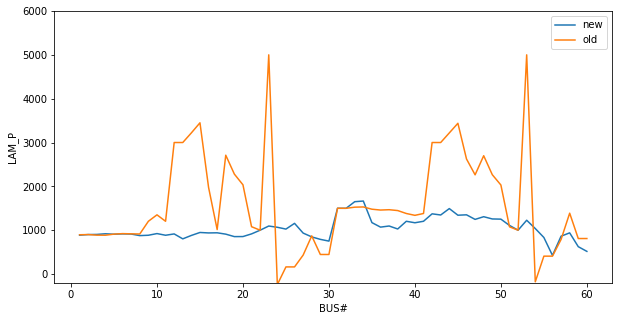

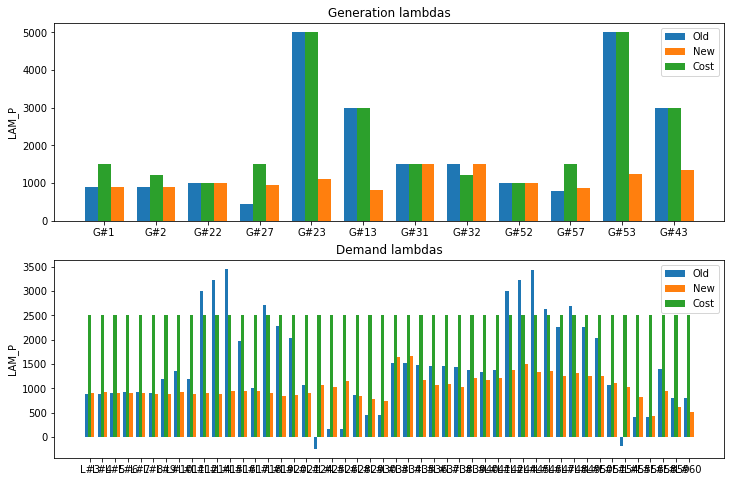

In [136]:
draw_nasty_profile(results_2hrs ,(-200, 6000))
gens = ppc_2hrs['gen'][:,0][ppc_2hrs['gencost'][:,4]>0]
draw_nice_hists(gens, results_2hrs)

In [125]:
sol_opt

{'mode': 0, 'lam_q': 1, 'mu': 2, 'sigma': 2}

In [126]:
alg

0

In [ ]:
#GET MULS
get_muls(results_2hrs, 2)['ls_int']

In [ ]:
get_muls(results_2hrs, 2)['us_int']

In [ ]:
get_muls(results_2hrs, 2)['ls_ram']

In [ ]:
get_muls(results_2hrs, 2)['us_ram']

In [ ]:
np.int64(results['bus'][:, LAM_P])